In [1]:
#Import Dependencies needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Import the department of Labor and Department of Commerce Excel Sheets into separate dataframes. 

In [2]:
#Importing the data as a dataframe

df_labor = pd.read_excel(r'CommerceLabor.xlsx', sheet_name='Department of Labor')

df_commerce = pd.read_excel(r'CommerceLabor.xlsx', sheet_name='Department of Commerce')

In [3]:
# Verify import worked, select one dataframe
df_labor

,RandomID,agency,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,POSTWT
0,114016000000,DL,4.0,3.0,5.0,5.0,4.0,4.0,5.0,4,...,B,B,B,B,B,B,A,B,A,1.430425
1,137377000000,DL,2.0,2.0,5.0,4.0,4.0,2.0,5.0,2,...,B,B,B,B,A,B,B,B,A,1.712627
2,131212000000,DL,5.0,4.0,4.0,4.0,2.0,4.0,5.0,5,...,B,B,A,B,A,A,A,A,A,1.532551
3,193260000000,DL,4.0,1.0,2.0,4.0,2.0,2.0,4.0,2,...,B,B,B,A,A,A,B,A,C,2.302167
4,197278000000,DL,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3,...,B,A,B,A,A,A,A,B,C,2.918573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,DL,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,...,A,B,B,A,A,A,A,B,A,1.659817
7546,189629000000,DL,4.0,4.0,3.0,4.0,4.0,2.0,3.0,2,...,C,B,B,A,A,A,B,B,D,1.464702
7547,125973000000,DL,4.0,4.0,4.0,4.0,4.0,4.0,4.0,X,...,C,B,B,A,A,A,B,B,A,1.464702
7548,164714000000,DL,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4,...,B,B,B,A,A,A,B,B,A,1.435365


#### Select Department of Labor dataframe and generate counts for each value and plot in bar charts along with the count values.

In [4]:
#Create an empty data frame
df_codebook = pd.DataFrame()

In [5]:
#create list of columns you want the value counts for
columns=['Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52','Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89']

#loop through list and add counts to codebook
for column in columns:
    value = df_labor[column].value_counts()
    df_codebook[column] = value
    
df_codebook.head()

,Q2,Q3,Q4,Q6,Q7,Q46,Q48,Q49,Q50,Q52,Q55,Q56,Q57,Q59,Q60,Q85,Q86,Q87,Q88,Q89
4.0,2790,3062,3489,2954,3350,2478,2189,2055,1949,1850,2501,2482,3346,2268,2591,2734,3199,2498,3302,2875
5.0,2184,2608,2720,1871,3260,3432,4123,4511,4038,4316,1551,2044,2058,2777,2279,1900,2434,2083,2780,3907
3.0,1200,977,646,1242,515,779,547,449,718,773,1466,1222,988,1096,1327,1566,942,1651,857,420
2.0,799,484,391,827,194,320,277,169,319,266,826,394,442,410,527,724,422,652,166,37
1.0,466,307,212,514,157,280,221,195,321,199,789,569,406,445,529,361,254,399,156,50


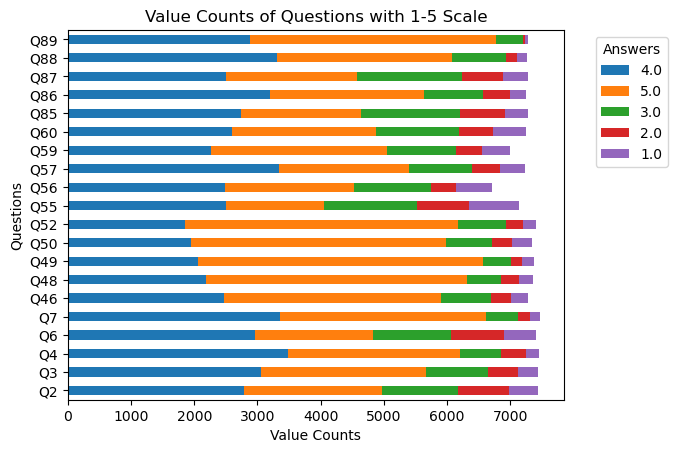

In [6]:
#Plot the dataframe using a horizontal bar graph
df_transposed = df_codebook.T
df_transposed.plot(kind="barh", stacked=True)
plt.title("Value Counts of Questions with 1-5 Scale")
plt.xlabel("Value Counts")
plt.ylabel("Questions")
plt.legend(title="Answers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Recode any variables where this is necessary. 

In [7]:
#Drop the columns that aren't necessary for the project as defined in the instructions

df_labor_relevant = df_labor[['RandomID', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q84', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL', 'DLEAVING']].copy()


### Deal With Missing Values
#### Identify and rows where a large number of responses are blank. Drop these rows.

In [8]:
#which rows don't have many answers? take the average of the missing data and get the proportion missing
df_labor_relevant['row_missing_percent']=df_labor_relevant.isnull().mean(axis=1)
df_labor_relevant[df_labor_relevant['row_missing_percent']!=0.0]

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
6,125154000000,4.0,4.0,3.0,3.0,5.0,2.0,4.0,3.0,2.0,...,NaN,NaN,NaN,NaN,A,NaN,NaN,B,NaN,0.225806
26,135718000000,4.0,4.0,4.0,4.0,5.0,3.0,3.0,4.0,3.0,...,NaN,B,B,NaN,A,NaN,NaN,B,A,0.129032
35,193123000000,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,3.0,...,B,B,A,B,A,B,A,A,NaN,0.032258
36,157819000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,0.258065
42,195486000000,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,2.0,...,B,B,B,B,B,B,A,B,A,0.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7527,159311000000,NaN,4.0,4.0,4.0,4.0,3.0,4.0,5.0,2.0,...,NaN,A,B,B,B,A,B,B,C,0.064516
7528,150181000000,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,...,NaN,NaN,B,B,A,A,A,B,C,0.064516
7531,141739000000,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,0.258065
7534,148644000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,1.0,1.0,...,NaN,NaN,B,B,A,A,A,B,C,0.064516


<Axes: >

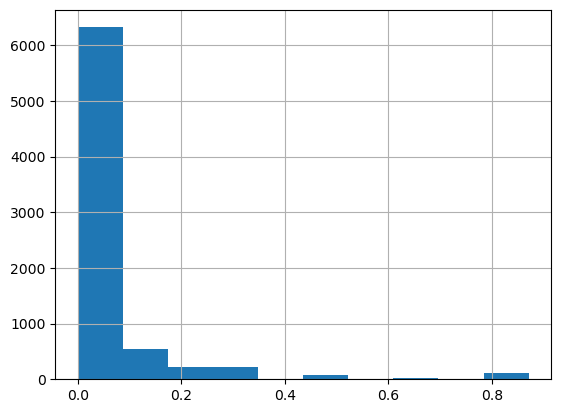

In [9]:
#plot histogram to check
df_labor_relevant['row_missing_percent'].hist()

In [10]:
# drop rows with %missing more than 50% missing data
cutpoint = .5
#drop rows w
df_labor_relevant_answered = df_labor_relevant.loc[df_labor_relevant['row_missing_percent']<cutpoint]
df_labor_relevant_answered

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,B,B,B,B,B,B,A,B,A,0.0
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,B,B,B,B,A,B,B,B,A,0.0
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,A,B,A,A,A,A,A,0.0
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,B,B,B,A,A,A,B,A,C,0.0
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,B,A,B,A,A,A,A,B,C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,A,B,B,A,A,A,A,B,A,0.0
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,C,B,B,A,A,A,B,B,D,0.0
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,C,B,B,A,A,A,B,B,A,0.0
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,B,A,A,A,B,B,A,0.0


In [11]:
df_labor_relevant_answered.drop(labels='row_missing_percent', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
#drop rows where the outcome variable is missing (this is what we are studying)
df_labor_relevant_answered = df_labor_relevant_answered.loc[df_labor_relevant_answered['DLEAVING'].isin(['A', 'B', 'C', 'D'])]
df_labor_relevant_answered

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,Q52,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,2.0,B,B,B,B,B,B,A,B,A
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,2.0,B,B,B,B,A,B,B,B,A
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,B,B,A,B,A,A,A,A,A
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,1.0,B,B,B,A,A,A,B,A,C
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,5.0,B,A,B,A,A,A,A,B,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,A,B,B,A,A,A,A,B,A
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,2.0,C,B,B,A,A,A,B,B,D
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,C,B,B,A,A,A,B,B,A
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,B,B,B,A,A,A,B,B,A


####   Check to see if any variables have blank/missing for more than 10% of their values. Decide whether you want to drop these variables. If you retain them consider running the models with and without those variables.

In [13]:
#Check to see if any variables have blank/missing calculate percent missing for column
missing_df = pd.DataFrame(df_labor_relevant_answered.isnull().mean()).reset_index()
missing_df.rename({'index':'variable_name',0:'percent_missing'}, axis=1, inplace=True)
missing_df

,variable_name,percent_missing
0,RandomID,0.000000
1,Q85,0.005837
2,Q86,0.010251
3,Q87,0.006264
4,Q88,0.008969
5,Q89,0.005410
6,Q2,0.013240
7,Q3,0.014237
8,Q4,0.012386
9,Q6,0.017938


#### For the variables with blank/missing or ‘Do Not Know’ values either recode those values to the median of the other values.

In [14]:
# convert X to missing
df_labor_recoded = df_labor_relevant_answered.replace(r'X', np.nan, regex=True)
df_labor_recoded

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,Q52,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,2.0,B,B,B,B,B,B,A,B,A
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,2.0,B,B,B,B,A,B,B,B,A
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,B,B,A,B,A,A,A,A,A
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,1.0,B,B,B,A,A,A,B,A,C
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,5.0,B,A,B,A,A,A,A,B,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,A,B,B,A,A,A,A,B,A
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,2.0,C,B,B,A,A,A,B,B,D
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,C,B,B,A,A,A,B,B,A
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,B,B,B,A,A,A,B,B,A


In [15]:
# put the columns in a list
df_labor_columns = df_labor_recoded.columns.tolist()
df_labor_columns

['RandomID',
 'Q85',
 'Q86',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q84',
 'Q55',
 'Q56',
 'Q57',
 'Q59',
 'Q60',
 'Q46',
 'Q48',
 'Q49',
 'Q50',
 'Q52',
 'DRNO',
 'DHISP',
 'DDIS',
 'DAGEGRP',
 'DSUPER',
 'DFEDTEN',
 'DSEX',
 'DMIL',
 'DLEAVING']

In [16]:
#impute with mode (doesn't mess with distribution)
for impute_column in df_labor_columns:
    df_labor_recoded[impute_column].fillna(df_labor_recoded[impute_column].mode()[0], inplace=True)

In [17]:
df_labor_recoded

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,Q52,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,2.0,B,B,B,B,B,B,A,B,A
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,2.0,B,B,B,B,A,B,B,B,A
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,B,B,A,B,A,A,A,A,A
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,1.0,B,B,B,A,A,A,B,A,C
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,5.0,B,A,B,A,A,A,A,B,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,A,B,B,A,A,A,A,B,A
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,2.0,C,B,B,A,A,A,B,B,D
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,C,B,B,A,A,A,B,B,A
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,B,B,B,A,A,A,B,B,A


#### Create a dummy variable for each row that captures whether any recodes were done. You will use this as an additional variable in your model.

#### For Question 84 you will need to create dummy codes. Plot the distribution of values and decide whether to create dummies for each value or whether to combine some. Describe why you made the choice you did.

In [18]:
df_labor_recoded['Q84'].value_counts()

4    2936
Y    1533
5    1452
3     771
2     175
1     157
Name: Q84, dtype: int64

In [19]:
#turn variable into a binary variable (do you have any unmet needs or is this org failing to meet your needs)
#Reducing it to either Needs are met 
df_labor_recoded['Q84'] = np.where(df_labor_recoded['Q84'].isin(['1', '2']),1,0)

In [20]:
df_labor_recoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 0 to 7549
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RandomID  7024 non-null   int64  
 1   Q85       7024 non-null   float64
 2   Q86       7024 non-null   float64
 3   Q87       7024 non-null   float64
 4   Q88       7024 non-null   float64
 5   Q89       7024 non-null   float64
 6   Q2        7024 non-null   float64
 7   Q3        7024 non-null   float64
 8   Q4        7024 non-null   float64
 9   Q6        7024 non-null   float64
 10  Q7        7024 non-null   float64
 11  Q84       7024 non-null   int64  
 12  Q55       7024 non-null   float64
 13  Q56       7024 non-null   float64
 14  Q57       7024 non-null   float64
 15  Q59       7024 non-null   float64
 16  Q60       7024 non-null   float64
 17  Q46       7024 non-null   float64
 18  Q48       7024 non-null   float64
 19  Q49       7024 non-null   float64
 20  Q50       7024 non-null   floa

In [21]:
#change type for numeric vars
numeric_vars = []
for num_columns in numeric_vars:
    df_labor_recoded[num_columns]=df_labor_recoded[num_columns].astype(int)
    
df_labor_recoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 0 to 7549
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RandomID  7024 non-null   int64  
 1   Q85       7024 non-null   float64
 2   Q86       7024 non-null   float64
 3   Q87       7024 non-null   float64
 4   Q88       7024 non-null   float64
 5   Q89       7024 non-null   float64
 6   Q2        7024 non-null   float64
 7   Q3        7024 non-null   float64
 8   Q4        7024 non-null   float64
 9   Q6        7024 non-null   float64
 10  Q7        7024 non-null   float64
 11  Q84       7024 non-null   int64  
 12  Q55       7024 non-null   float64
 13  Q56       7024 non-null   float64
 14  Q57       7024 non-null   float64
 15  Q59       7024 non-null   float64
 16  Q60       7024 non-null   float64
 17  Q46       7024 non-null   float64
 18  Q48       7024 non-null   float64
 19  Q49       7024 non-null   float64
 20  Q50       7024 non-null   floa

#### Recode the demographic variables using dummies

In [22]:
#(6) get dummies for variables in Demographic Codes (DO NOT DO THIS FOR OUTCOME & Q84)
demo_dummies = pd.get_dummies(df_labor_recoded, columns=['DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL'])

demo_dummies.tail()

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DAGEGRP_B,DSUPER_A,DSUPER_B,DFEDTEN_A,DFEDTEN_B,DFEDTEN_C,DSEX_A,DSEX_B,DMIL_A,DMIL_B
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,0,1,0,1,0,0,1,0,0,1
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,0,1,0,1,0,0,0,1,0,1
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1
7549,177361000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1


In [23]:
demo_dummies.columns.to_list()

['RandomID',
 'Q85',
 'Q86',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q84',
 'Q55',
 'Q56',
 'Q57',
 'Q59',
 'Q60',
 'Q46',
 'Q48',
 'Q49',
 'Q50',
 'Q52',
 'DLEAVING',
 'DRNO_A',
 'DRNO_B',
 'DRNO_C',
 'DRNO_D',
 'DHISP_A',
 'DHISP_B',
 'DDIS_A',
 'DDIS_B',
 'DAGEGRP_A',
 'DAGEGRP_B',
 'DSUPER_A',
 'DSUPER_B',
 'DFEDTEN_A',
 'DFEDTEN_B',
 'DFEDTEN_C',
 'DSEX_A',
 'DSEX_B',
 'DMIL_A',
 'DMIL_B']

#### Recode the outcome variable so that 0 if ‘No’ (‘A’) or 1 if anything else ‘Yes’ (‘B’, ‘C’, ‘D’) 

In [24]:
demo_dummies['DLEAVING'] = np.where(demo_dummies['DLEAVING'] == 'A', 0, 1)

demo_dummies

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DAGEGRP_B,DSUPER_A,DSUPER_B,DFEDTEN_A,DFEDTEN_B,DFEDTEN_C,DSEX_A,DSEX_B,DMIL_A,DMIL_B
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,1,0,1,0,1,0,1,0,0,1
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,1,1,0,0,1,0,0,1,0,1
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,1,1,0,1,0,0,1,0,1,0
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,0,1,0,1,0,0,0,1,1,0
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,0,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,0,1,0,1,0,0,1,0,0,1
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,0,1,0,1,0,0,0,1,0,1
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1


####  Combine all of the variables back into a single dataframe

In [25]:
combined_labor_df = demo_dummies.copy()
combined_labor_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 0 to 7549
Data columns (total 42 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RandomID   7024 non-null   int64  
 1   Q85        7024 non-null   float64
 2   Q86        7024 non-null   float64
 3   Q87        7024 non-null   float64
 4   Q88        7024 non-null   float64
 5   Q89        7024 non-null   float64
 6   Q2         7024 non-null   float64
 7   Q3         7024 non-null   float64
 8   Q4         7024 non-null   float64
 9   Q6         7024 non-null   float64
 10  Q7         7024 non-null   float64
 11  Q84        7024 non-null   int64  
 12  Q55        7024 non-null   float64
 13  Q56        7024 non-null   float64
 14  Q57        7024 non-null   float64
 15  Q59        7024 non-null   float64
 16  Q60        7024 non-null   float64
 17  Q46        7024 non-null   float64
 18  Q48        7024 non-null   float64
 19  Q49        7024 non-null   float64
 20  Q50     

In [26]:
combined_labor_df.columns.to_list()

['RandomID',
 'Q85',
 'Q86',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q84',
 'Q55',
 'Q56',
 'Q57',
 'Q59',
 'Q60',
 'Q46',
 'Q48',
 'Q49',
 'Q50',
 'Q52',
 'DLEAVING',
 'DRNO_A',
 'DRNO_B',
 'DRNO_C',
 'DRNO_D',
 'DHISP_A',
 'DHISP_B',
 'DDIS_A',
 'DDIS_B',
 'DAGEGRP_A',
 'DAGEGRP_B',
 'DSUPER_A',
 'DSUPER_B',
 'DFEDTEN_A',
 'DFEDTEN_B',
 'DFEDTEN_C',
 'DSEX_A',
 'DSEX_B',
 'DMIL_A',
 'DMIL_B']

## Correlation Matrix

#### Creat a correlation matric in the form of a heatmap.

In [27]:

# Select the columns you need for Matrix
selected_columns = ['Q85',
 'Q86',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q55',
 'Q56',
 'Q57',
 'Q59',
 'Q60',
 'Q46',
 'Q48',
 'Q49',
 'Q50',
 'Q52',]

# Create a new DataFrame with only the selected columns
corr_df = combined_labor_df[selected_columns].copy()
corr_df

,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,Q7,Q55,Q56,Q57,Q59,Q60,Q46,Q48,Q49,Q50,Q52
0,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,5.0,3.0,3.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,2.0
1,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,5.0,2.0,3.0,1.0,1.0,4.0,1.0,1.0,2.0,1.0,2.0
2,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0
4,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
7546,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,3.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,4.0,3.0,2.0
7547,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,5.0
7548,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


<Axes: >

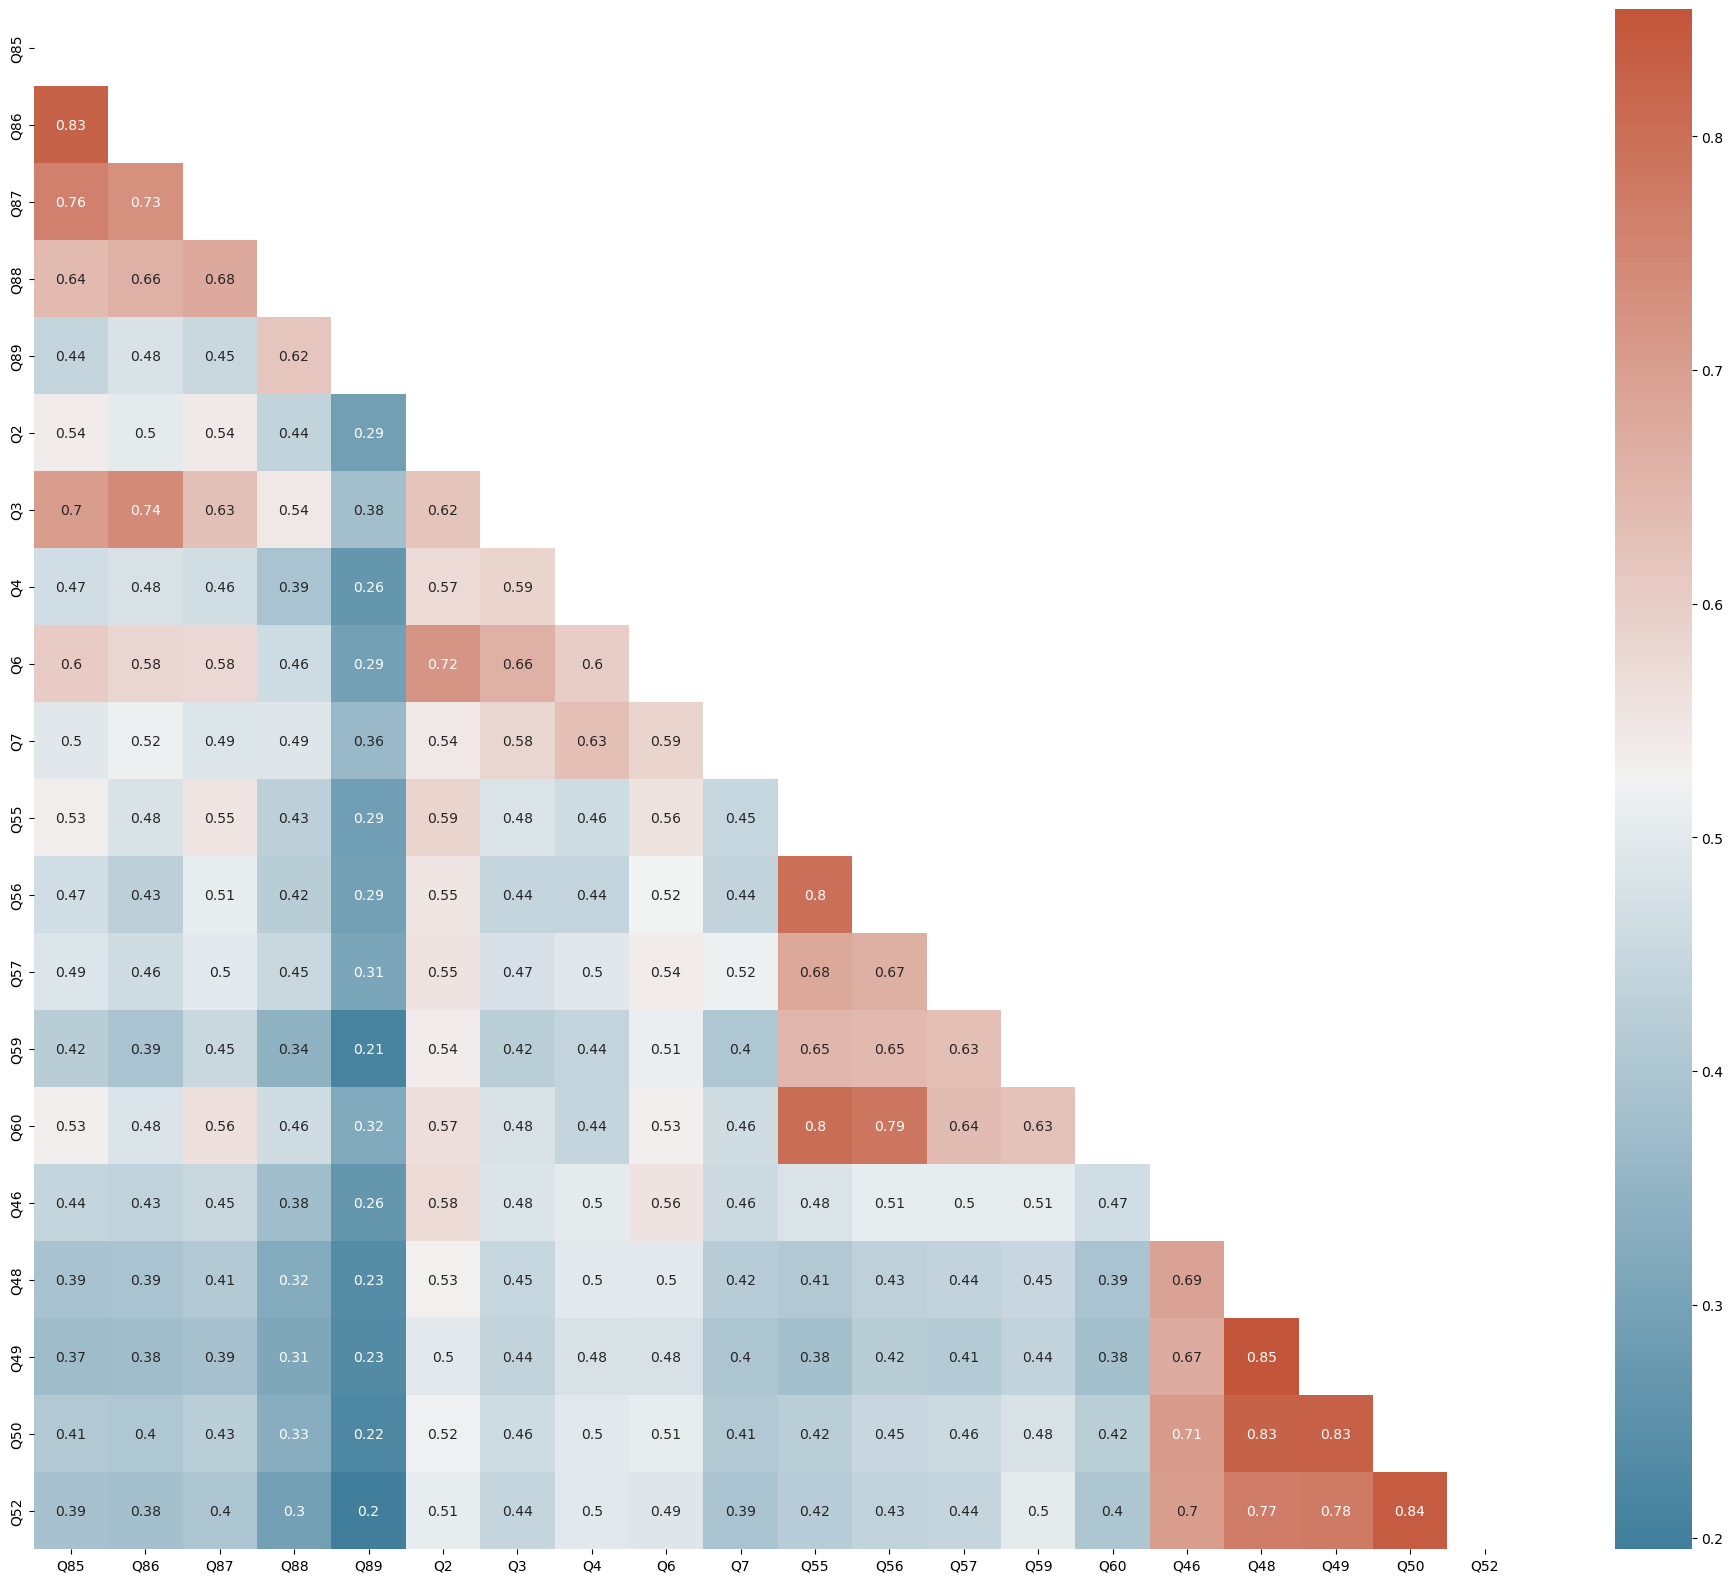

In [28]:

# Correlation between different variables (do not include Dummy Variables)
# Create a subset df specify the data we need 
corr = corr_df.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(24, 20))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

#### Identify any variables that are correlated more than .8

In [29]:
#Identify any variables that are correlated more than .8
#Export Correlation to a DF
corr = corr_df.corr()
corr_matrix_df = pd.DataFrame(corr)
corr_matrix_df


,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,Q7,Q55,Q56,Q57,Q59,Q60,Q46,Q48,Q49,Q50,Q52
Q85,1.000000,0.826676,0.763876,0.641612,0.440585,0.537589,0.700245,0.466534,0.604666,0.495038,0.533070,0.468176,0.486789,0.420843,0.530167,0.443147,0.389918,0.371933,0.406627,0.388174
Q86,0.826676,1.000000,0.728287,0.663395,0.480686,0.501788,0.743209,0.477435,0.583360,0.519076,0.479486,0.428306,0.461972,0.391768,0.483598,0.432896,0.391052,0.375175,0.402212,0.383095
Q87,0.763876,0.728287,1.000000,0.678421,0.450243,0.542391,0.628133,0.464201,0.577785,0.486676,0.551546,0.507268,0.499895,0.451964,0.562054,0.451310,0.410208,0.387659,0.425219,0.397336
Q88,0.641612,0.663395,0.678421,1.000000,0.617566,0.435120,0.544428,0.391059,0.458034,0.491659,0.429010,0.421372,0.450864,0.343520,0.462915,0.375779,0.322764,0.313140,0.331150,0.295308
Q89,0.440585,0.480686,0.450243,0.617566,1.000000,0.288900,0.378961,0.264313,0.292004,0.363902,0.286834,0.294647,0.307501,0.210902,0.316704,0.263557,0.234436,0.233563,0.222563,0.195263
Q2,0.537589,0.501788,0.542391,0.435120,0.288900,1.000000,0.621289,0.574884,0.718831,0.543729,0.588714,0.551444,0.554775,0.537191,0.565758,0.575150,0.528090,0.496520,0.521239,0.508586
Q3,0.700245,0.743209,0.628133,0.544428,0.378961,0.621289,1.000000,0.588140,0.660555,0.582002,0.481080,0.444579,0.474032,0.423128,0.477863,0.484420,0.447279,0.437702,0.458556,0.442804
Q4,0.466534,0.477435,0.464201,0.391059,0.264313,0.574884,0.588140,1.000000,0.601908,0.631604,0.459903,0.441878,0.496169,0.441261,0.443012,0.503388,0.496856,0.477327,0.497009,0.496726
Q6,0.604666,0.583360,0.577785,0.458034,0.292004,0.718831,0.660555,0.601908,1.000000,0.588650,0.556368,0.522944,0.538276,0.512078,0.531563,0.555171,0.500198,0.478061,0.507232,0.493562
Q7,0.495038,0.519076,0.486676,0.491659,0.363902,0.543729,0.582002,0.631604,0.588650,1.000000,0.445011,0.439710,0.517311,0.401497,0.462760,0.457522,0.416931,0.398298,0.408444,0.393341


In [30]:
# Loop over bottom diagonal of correlation matrix
for i in range(len(corr_matrix_df.columns)):
    for j in range(i):

        # Print variables with high correlation
        if abs(corr_matrix_df.iloc[i, j]) > 0.8:
            print(corr_matrix_df.columns[i], corr_matrix_df.columns[j], corr_matrix_df.iloc[i, j])



Q86 Q85 0.8266764152872864
Q60 Q55 0.8034478435391257
Q49 Q48 0.854392551003546
Q50 Q48 0.8272975334173097
Q50 Q49 0.829866089300193
Q52 Q50 0.841416917106258


####    Either drop one (or more if several all highly correlated) or average them and create a new variable. For the variables that are grouped together in the codebook, it is more likely that they will highly correlate with each other. If this is the case, you can decide whether you want to take the average of those questions and just use the composite variable.

In [31]:
#if you find a dataset that is strongly correlated you can collapse into a set by averaging

combined_labor_df['Q86_85']=(combined_labor_df['Q86']+combined_labor_df['Q85'])/2
combined_labor_df['Q60_55']=(combined_labor_df['Q60']+combined_labor_df['Q55'])/2
combined_labor_df['Q48_49_50_52']=(combined_labor_df['Q48']+combined_labor_df['Q49'])+(combined_labor_df['Q50']+combined_labor_df['Q52'])/4


In [32]:
combined_labor_df.columns.to_list()

['RandomID',
 'Q85',
 'Q86',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q84',
 'Q55',
 'Q56',
 'Q57',
 'Q59',
 'Q60',
 'Q46',
 'Q48',
 'Q49',
 'Q50',
 'Q52',
 'DLEAVING',
 'DRNO_A',
 'DRNO_B',
 'DRNO_C',
 'DRNO_D',
 'DHISP_A',
 'DHISP_B',
 'DDIS_A',
 'DDIS_B',
 'DAGEGRP_A',
 'DAGEGRP_B',
 'DSUPER_A',
 'DSUPER_B',
 'DFEDTEN_A',
 'DFEDTEN_B',
 'DFEDTEN_C',
 'DSEX_A',
 'DSEX_B',
 'DMIL_A',
 'DMIL_B',
 'Q86_85',
 'Q60_55',
 'Q48_49_50_52']

In [33]:
reduced_labor_df_corr = combined_labor_df[[
 'Q86_85',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q56',
 'Q57',
 'Q59',
 'Q60_55',
 'Q46',
 'Q48_49_50_52']]

#### Once you have dropped and variables and/or created composites, create a new correlation matrix.

<Axes: >

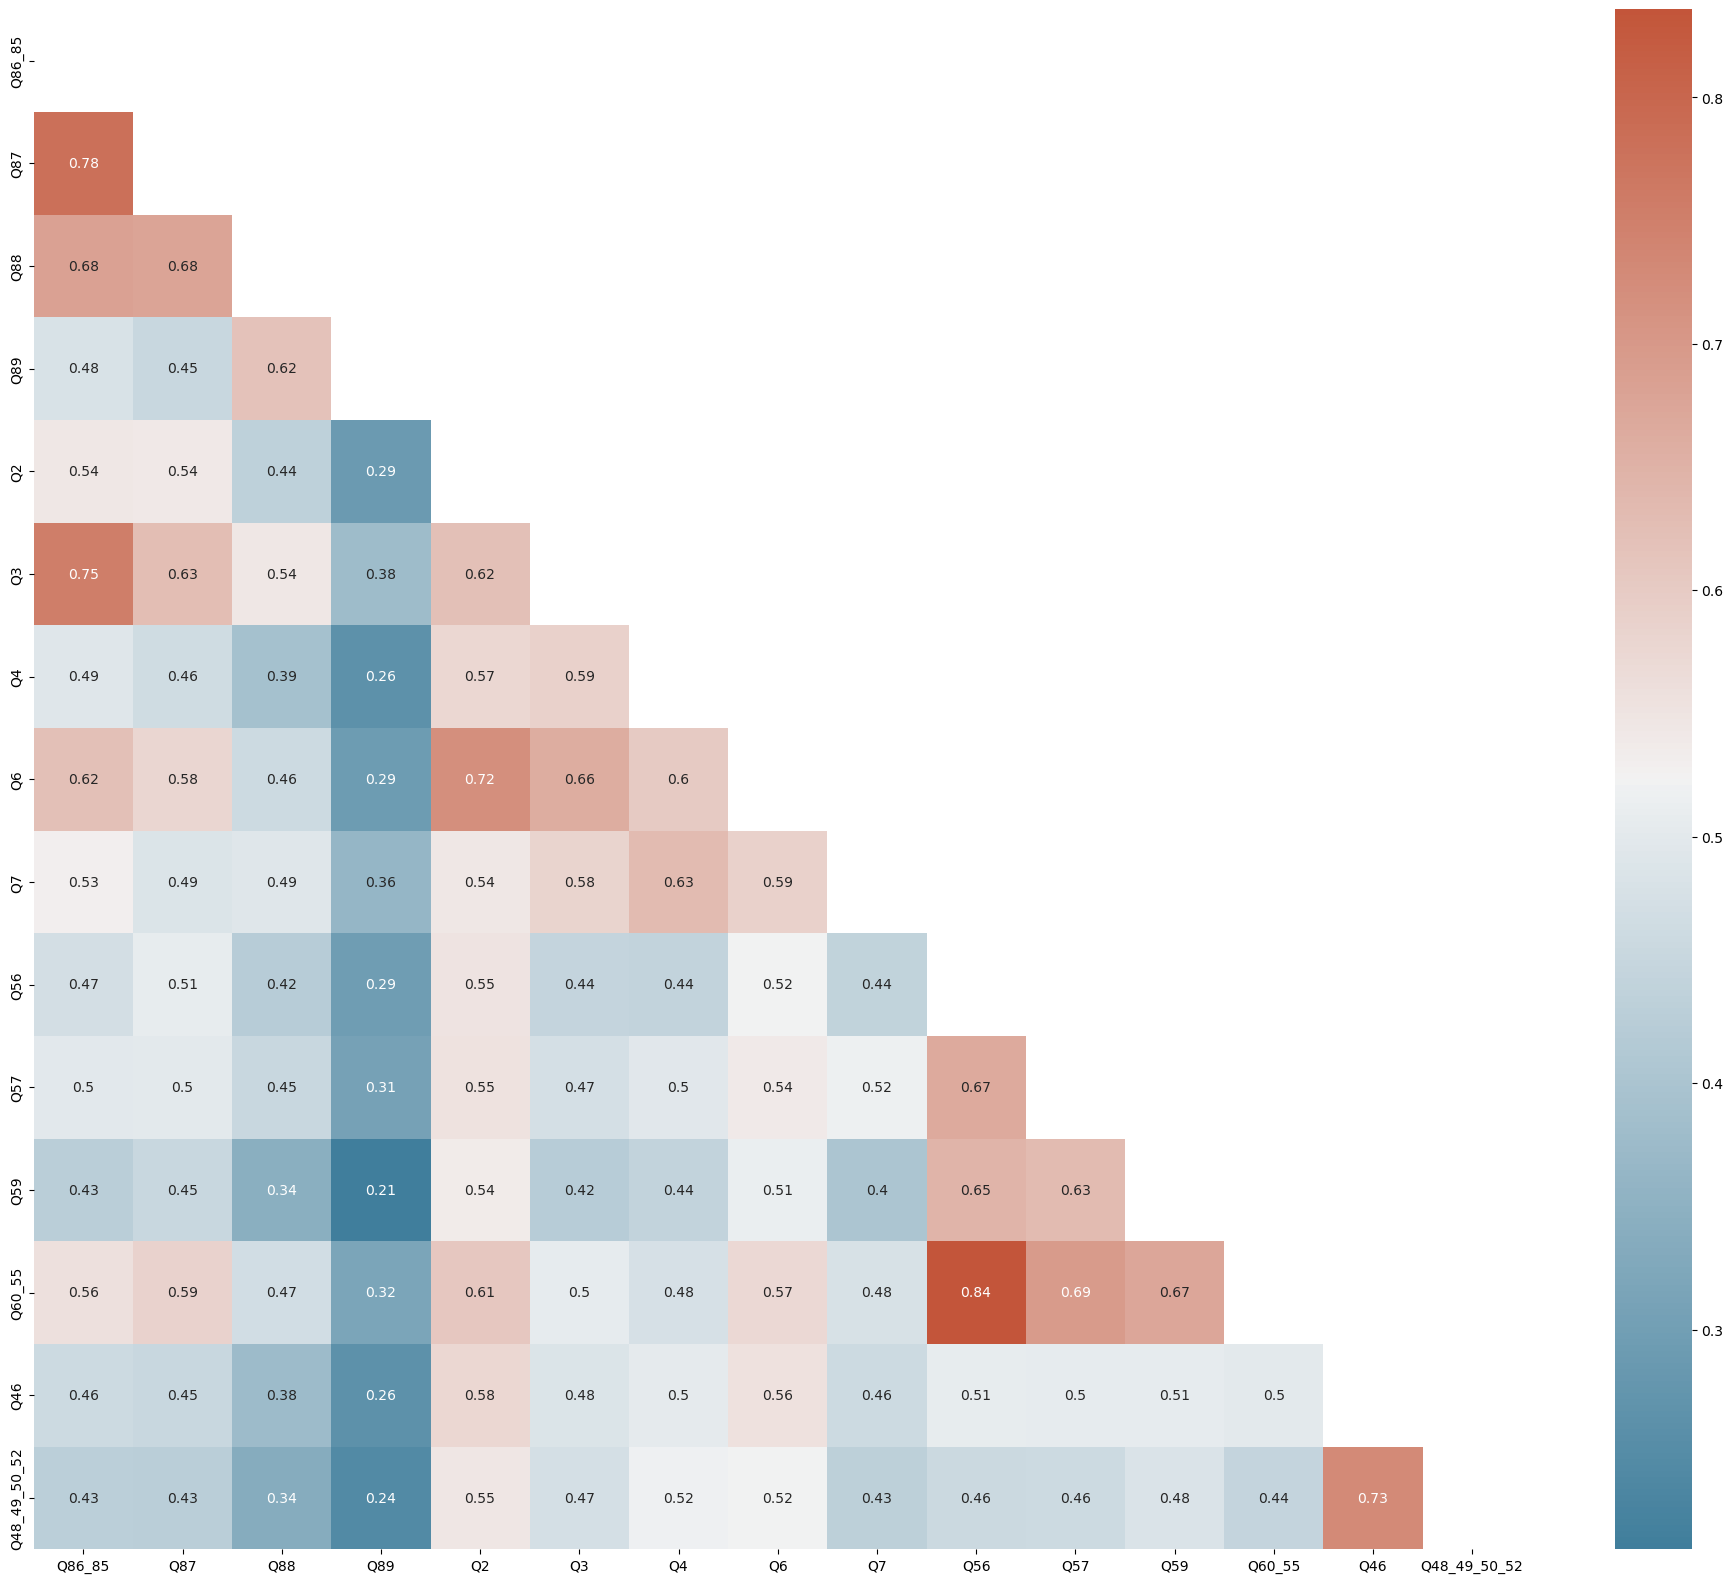

In [34]:

# Correlation between different variables (do not include Dummy Variables)
# Create a subset df specify the data we need 
corr = reduced_labor_df_corr.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(24, 20))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

##### Split your data in training and test sets. When doing this remember to set the random seed to a number that you will keep constant.

In [35]:
combined_labor_df.columns.to_list()

['RandomID',
 'Q85',
 'Q86',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q84',
 'Q55',
 'Q56',
 'Q57',
 'Q59',
 'Q60',
 'Q46',
 'Q48',
 'Q49',
 'Q50',
 'Q52',
 'DLEAVING',
 'DRNO_A',
 'DRNO_B',
 'DRNO_C',
 'DRNO_D',
 'DHISP_A',
 'DHISP_B',
 'DDIS_A',
 'DDIS_B',
 'DAGEGRP_A',
 'DAGEGRP_B',
 'DSUPER_A',
 'DSUPER_B',
 'DFEDTEN_A',
 'DFEDTEN_B',
 'DFEDTEN_C',
 'DSEX_A',
 'DSEX_B',
 'DMIL_A',
 'DMIL_B',
 'Q86_85',
 'Q60_55',
 'Q48_49_50_52']

#### Step 1: Create the labels set (`y`)  from the “DLEAVING” column, and then create the features (`X`) DataFrame from the remaining columns.

In [36]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = combined_labor_df['DLEAVING']

# Separate the X variable, the features
X = combined_labor_df.drop(columns=['RandomID', 'DLEAVING', 'Q48', 'Q49', 'Q50','Q60', 'Q85', 'Q86','Q52','Q55','DRNO_D','DHISP_B', 'DDIS_B','DAGEGRP_B', 'DSUPER_B','DFEDTEN_C','DSEX_B','DMIL_B'])

In [37]:
# Review the y variable Series
y[:5]

0    0
1    0
2    0
3    1
4    1
Name: DLEAVING, dtype: int64

In [38]:
# Review the X variable DataFrame
X.head()

,Q87,Q88,Q89,Q2,Q3,Q4,Q6,Q7,Q84,Q56,...,DDIS_A,DAGEGRP_A,DSUPER_A,DFEDTEN_A,DFEDTEN_B,DSEX_A,DMIL_A,Q86_85,Q60_55,Q48_49_50_52
0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,1,1,0,4.0,3.5,8.25
1,5.0,5.0,5.0,2.0,5.0,4.0,2.0,5.0,0,3.0,...,0,0,1,0,1,0,0,5.0,3.0,3.75
2,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,0,5.0,...,1,0,1,1,0,1,1,3.5,5.0,12.50
3,1.0,2.0,5.0,1.0,2.0,4.0,2.0,4.0,0,4.0,...,0,1,1,1,0,0,1,2.0,2.5,2.50
4,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,0,4.0,...,0,1,1,1,0,1,0,3.0,4.0,10.50


#### Step 2: Check the balance of the labels variable (`y`) by using the `value_counts` function.

In [39]:
# Check the balance of our target values
y.value_counts()

0    4779
1    2245
Name: DLEAVING, dtype: int64

#### Step 3: Split the data into training and testing datasets by using `train_test_split`.

In [40]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Logistic Regresssion


---
### Part 1

##### Create a Logistic Regression Model 

####  Run a logistic regression on the training data (`X_train` and `y_train`) setting the penalty parameter to ‘None’ in SKLearn.
---

In [41]:
# Instantiate the Logistic Regression model
maxiter=200
lr_classifier = LogisticRegression(penalty=None, solver='lbfgs', random_state=1, max_iter=maxiter)



In [42]:
# Fit the model on the test data
lr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, penalty=None, random_state=1)

#### Save the predictions on the testing data labels by using the testing feature data (`X_test`) and the fitted model.

In [43]:
# Make a prediction using the testing data
predictions = lr_classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)


,Prediction,Actual
0,0,1
1,0,1
2,0,0
3,0,0
4,1,1
5,0,0
6,0,0
7,0,0
8,0,1
9,0,1


In [44]:
results['Prediction'].mean()

0.18223234624145787

### Evaluate the model’s performance: Generate a confusion matrix.


In [45]:
# Print the balanced_accuracy score of the model
# Display the accuracy score for the test dataset.
balanced_accuracy = accuracy_score(y_test, predictions)
print(balanced_accuracy)

0.7625284738041003


In [46]:
# Generate a confusion matrix for the model
lr_cm = confusion_matrix(y_test, predictions)
lr_cm_df = pd.DataFrame(
    lr_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(lr_cm_df)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1106,87
Actual 1,330,233


In [47]:
# Print the classification report for the model
print("Classification Report Logistic Regression Penalty Parameter=None")
print(classification_report(y_test, predictions))

Classification Report Logistic Regression Penalty Parameter=None
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1193
           1       0.73      0.41      0.53       563

    accuracy                           0.76      1756
   macro avg       0.75      0.67      0.68      1756
weighted avg       0.76      0.76      0.74      1756



### Part 2


In [48]:
# Run a second logistic regression model setting the penalty parament to 'l2'
# Instantiate the Logistic Regression model
lr_classifier2 = LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, max_iter=maxiter)

In [49]:
# Fit the model on the test data
lr_classifier2.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [50]:
# Make a prediction using the testing data
predictions2 = lr_classifier2.predict(X_test)
results2 = pd.DataFrame({"Prediction": predictions2, "Actual": y_test}).reset_index(drop=True)
results2.mean()


Prediction    0.182232
Actual        0.320615
dtype: float64

In [51]:
# Print the balanced_accuracy score of the model
# Display the accuracy score for the test dataset.
balanced_accuracy2 = accuracy_score(y_test, predictions2)
print(balanced_accuracy2)

0.7613895216400911


In [52]:
# Generate a confusion matrix for the model
lr_cm2 = confusion_matrix(y_test, predictions2)
lr_cm_df2 = pd.DataFrame(
    lr_cm2, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(lr_cm_df2)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1105,88
Actual 1,331,232


In [53]:
# Print the classification report for the model
print("Classification Report LogisticRegression penalty='l2'")
print(classification_report(y_test, predictions2))

Classification Report LogisticRegression penalty='l2'
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1193
           1       0.72      0.41      0.53       563

    accuracy                           0.76      1756
   macro avg       0.75      0.67      0.68      1756
weighted avg       0.76      0.76      0.74      1756



### Random Forest

In [54]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [55]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [56]:
 # Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [57]:
 # Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [58]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [59]:
# Making predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

In [60]:
# Calculating the confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
rf_cm_df = pd.DataFrame(
    rf_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(rf_cm_df)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1079,114
Actual 1,306,257


In [61]:
# Print the balanced_accuracy score of the model
# Display the accuracy score for the test dataset.
balanced_accuracyrf = accuracy_score(y_test, rf_predictions)
print(balanced_accuracyrf)

0.7608200455580866


In [62]:
# Print the classification report for the model
print("Classification Report")
print(classification_report(y_test, rf_predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1193
           1       0.69      0.46      0.55       563

    accuracy                           0.76      1756
   macro avg       0.74      0.68      0.69      1756
weighted avg       0.75      0.76      0.75      1756



### Compare best logistic regression model with random forest
----


### Visualize the Best Model


---

In [63]:
shap.initjs()

In [64]:
#Setting up SHAP Explainer
explainer = shap.Explainer(lr_classifier.predict, X)
shap_values = explainer(X_test)

PermutationExplainer explainer: 1757it [01:10, 22.37it/s]                          


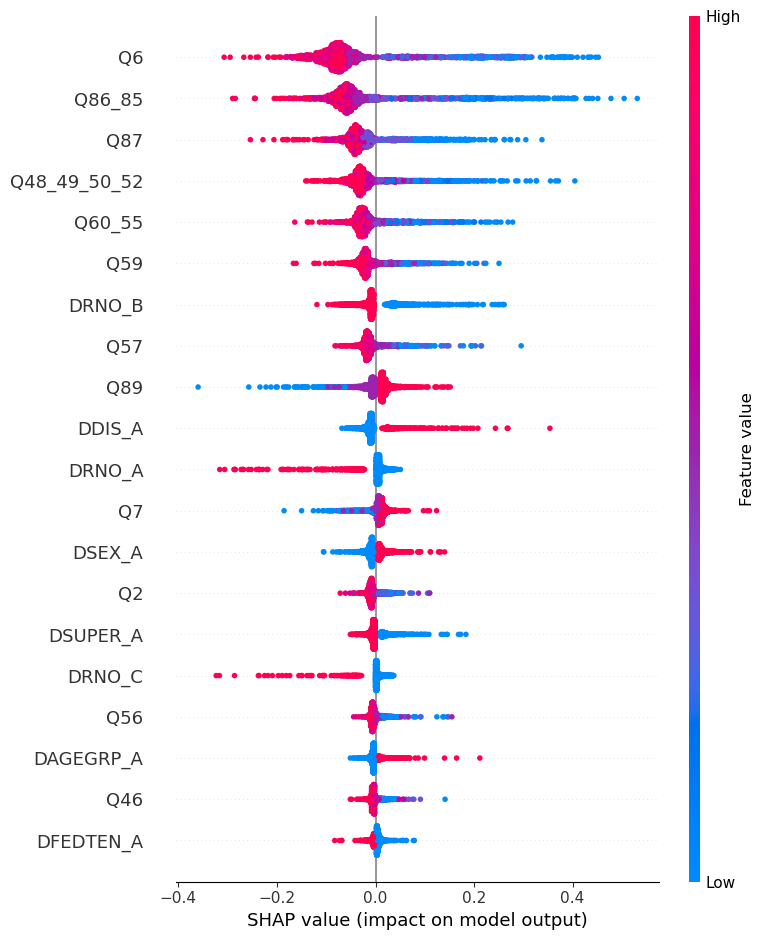

In [65]:
shap.summary_plot(shap_values, X_test)

In [66]:
#Setting up SHAP Explainer
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)

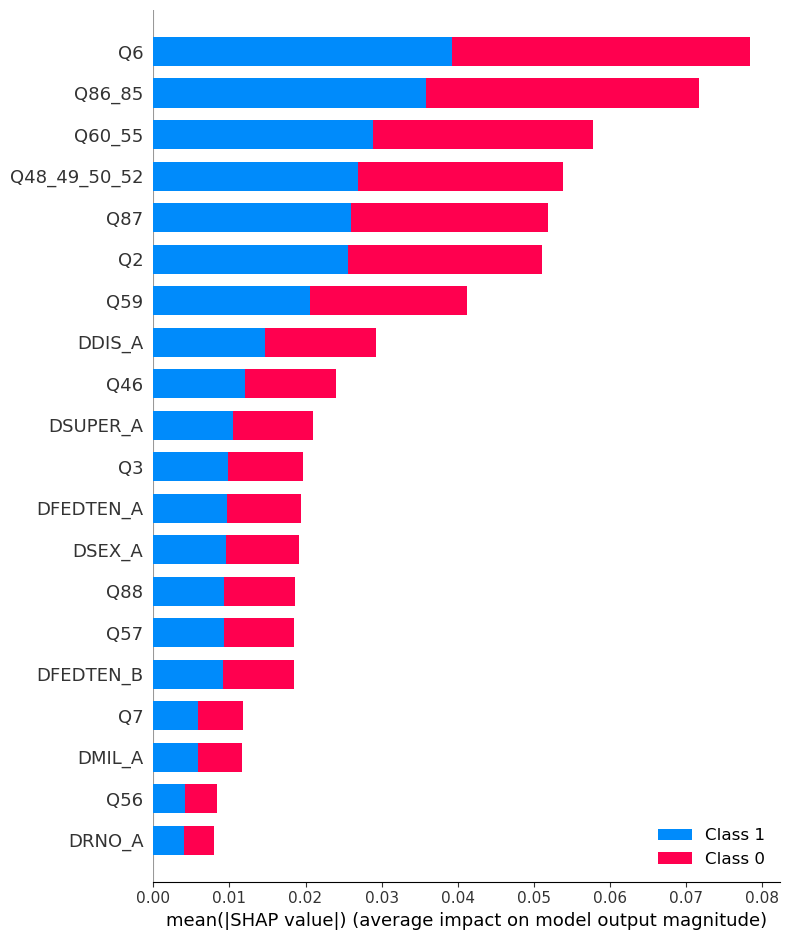

In [67]:
shap.summary_plot(shap_values, X_test)

# Test with data from other Commerce Dept
----

In [68]:
df_commerce

,RandomID,agency,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,POSTWT
0,171638000000,CM,2.0,2.0,4.0,4.0,3.0,3.0,3.0,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.337775
1,159842000000,CM,4.0,4.0,5.0,5.0,2.0,4.0,5.0,4,...,B,B,B,B,A,B,A,A,B,1.776877
2,160709000000,CM,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5,...,B,B,B,B,B,C,A,B,A,2.130467
3,135627000000,CM,4.0,2.0,3.0,3.0,4.0,2.0,4.0,4,...,B,B,A,B,A,C,B,B,A,2.060351
4,118318000000,CM,4.0,3.0,4.0,4.0,3.0,4.0,4.0,5,...,B,B,B,B,B,C,A,B,A,3.359444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21004,165175000000,CM,5.0,5.0,5.0,3.0,4.0,3.0,4.0,5,...,B,B,B,B,A,A,A,B,B,2.669508
21005,197454000000,CM,5.0,4.0,5.0,5.0,4.0,5.0,5.0,5,...,A,B,B,A,A,A,B,B,A,1.696301
21006,106631000000,CM,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4,...,C,B,B,A,A,A,B,B,A,1.696301
21007,152121000000,CM,4.0,2.0,1.0,5.0,1.0,1.0,4.0,5,...,C,B,B,A,A,A,A,B,B,2.064273


## Recode any variables where this is necessary. 
---

In [69]:
#Drop the columns that aren't necessary for the project as defined in the instructions
df_commerce_relevant = df_commerce[['RandomID', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q84', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL', 'DLEAVING']].copy()


### Deal With Missing Values
#### Identify and rows where a large number of responses are blank. Drop these rows.

In [70]:
#which rows don't have many answers? take the average of the missing data and get the proportion missing
df_commerce_relevant['row_missing_percent']=df_commerce_relevant.isnull().mean(axis=1)
df_commerce_relevant[df_commerce_relevant['row_missing_percent']!=0.0]

# drop rows with %missing more than 50% missing data
cutpoint = .5
df_commerce_relevant_answered = df_commerce_relevant.loc[df_commerce_relevant['row_missing_percent']<cutpoint]

#drop column row_missing_percent
df_commerce_relevant_answered.drop('row_missing_percent', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [71]:
#drop rows where the outcome variable is missing (this is what we are studying)
df_commerce_relevant_answered = df_commerce_relevant_answered.loc[df_commerce_relevant_answered['DLEAVING'].isin(['A', 'B', 'C', 'D'])]


####   Check to see if any variables have blank/missing for more than 10% of their values. Decide whether you want to drop these variables. If you retain them consider running the models with and without those variables.

In [72]:
#Check to see if any variables have blank/missing calculate percent missing for column
missing_df = pd.DataFrame(df_commerce_relevant_answered.isnull().mean()).reset_index()
missing_df.rename({'index':'variable_name',0:'percent_missing'}, axis=1, inplace=True)
missing_df

,variable_name,percent_missing
0,RandomID,0.000000
1,Q85,0.007423
2,Q86,0.009931
3,Q87,0.005919
4,Q88,0.009580
5,Q89,0.005818
6,Q2,0.015499
7,Q3,0.013693
8,Q4,0.012439
9,Q6,0.018157


#### For the variables with blank/missing or ‘Do Not Know’ values either recode those values to the median of the other values.

In [73]:
# convert X to missing
df_commerce_recoded = df_commerce_relevant_answered.replace(r'X', np.nan, regex=True)

# put the columns in a list
df_commerce_recoded_columns = df_commerce_recoded.columns.tolist()

#impute with mode (doesn't mess with distribution)
for impute_column in df_commerce_recoded_columns:
    df_commerce_recoded[impute_column].fillna(df_commerce_recoded[impute_column].mode()[0], inplace=True)

#### For Question 84 you will need to create dummy codes. 

In [74]:
#turn variable into a binary variable (do you have any unmet needs or is this org failing to meet your needs)
#Reducing it to either Needs are met 
df_commerce_recoded['Q84'] = np.where(df_commerce_recoded['Q84'].isin(['1', '2']),1,0)

In [75]:
#change type for numeric vars
numeric_vars = []
for num_columns in numeric_vars:
    df_commerce_recoded[num_columns]=df_commerce_recoded[num_columns].astype(int)


#### Recode the demographic variables using dummies

In [76]:
#(6) get dummies for variables in Demographic Codes (DO NOT DO THIS FOR OUTCOME & Q84)
demo_dummies_commerce = pd.get_dummies(df_commerce_recoded, columns=['DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL'])



#### Recode the outcome variable so that 0 if ‘No’ (‘A’) or 1 if anything else ‘Yes’ (‘B’, ‘C’, ‘D’) 

In [77]:
demo_dummies_commerce['DLEAVING'] = np.where(demo_dummies_commerce['DLEAVING'] == 'A', 0, 1)

demo_dummies_commerce

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DAGEGRP_B,DSUPER_A,DSUPER_B,DFEDTEN_A,DFEDTEN_B,DFEDTEN_C,DSEX_A,DSEX_B,DMIL_A,DMIL_B
1,159842000000,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,...,1,1,0,0,1,0,1,0,1,0
2,160709000000,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1,0,1,0,0,1,1,0,0,1
3,135627000000,2.0,2.0,2.0,4.0,3.0,2.0,3.0,3.0,2.0,...,1,1,0,0,0,1,0,1,0,1
4,118318000000,4.0,5.0,4.0,4.0,5.0,3.0,4.0,4.0,4.0,...,1,0,1,0,0,1,1,0,0,1
5,134199000000,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,...,1,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21003,147105000000,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,0,1,0,1,0,0,1,0,0,1
21004,165175000000,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,3.0,...,1,1,0,1,0,0,1,0,0,1
21005,197454000000,5.0,5.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,...,0,1,0,1,0,0,0,1,0,1
21006,106631000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1


####  Combine all of the variables back into a single dataframe

In [78]:
combined_commerce_df = demo_dummies_commerce.copy()


#### Rename variables to be easier to interpret (suggest abbreviating or adding prefix or suffice to Q#)

In [79]:
#if you find a dataset that is strongly correlated you can collapse into a set by averaging
combined_commerce_df['Q86_85']=(combined_commerce_df['Q86']+combined_commerce_df['Q85'])/2
combined_commerce_df['Q60_55']=(combined_commerce_df['Q60']+combined_commerce_df['Q55'])/2
combined_commerce_df['Q48_49_50_52']=(combined_commerce_df['Q48']+combined_commerce_df['Q49'])+(combined_commerce_df['Q50']+combined_commerce_df['Q52'])/4


In [80]:
reduced_commerce_df = combined_commerce_df[[
 'Q86_85',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q56',
 'Q57',
 'Q59',
 'Q60_55',
 'Q46',
 'Q48_49_50_52']]

## Fit the data using your best model.
---

In [87]:
# Separate the data into labels and features
# Separate the y variable, the labels
y_commerce = combined_commerce_df['DLEAVING']

# Separate the X variable, the features
X_commerce = combined_commerce_df.drop(columns=['RandomID', 'DLEAVING', 'Q48', 'Q49', 'Q50','Q60', 'Q85', 'Q86','Q52','Q55','DRNO_D','DHISP_B', 'DDIS_B','DAGEGRP_B', 'DSUPER_B','DFEDTEN_C','DSEX_B','DMIL_B'])

In [88]:
# Review the y variable Series
y[:5]

1    1
2    0
3    0
4    0
5    0
Name: DLEAVING, dtype: int64

In [89]:
# Review the X variable DataFrame
X.head()

,Q87,Q88,Q89,Q2,Q3,Q4,Q6,Q7,Q84,Q56,...,DDIS_A,DAGEGRP_A,DSUPER_A,DFEDTEN_A,DFEDTEN_B,DSEX_A,DMIL_A,Q86_85,Q60_55,Q48_49_50_52
1,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,0,4.0,...,0,0,1,0,1,1,1,4.0,3.5,12.50
2,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0,5.0,...,0,0,0,0,0,1,0,4.5,4.0,12.50
3,2.0,4.0,3.0,2.0,3.0,3.0,2.0,4.0,0,3.0,...,1,0,1,0,0,0,0,2.0,2.5,9.25
4,4.0,4.0,5.0,3.0,4.0,4.0,4.0,4.0,0,4.0,...,0,0,0,0,0,1,0,4.5,3.5,12.50
5,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,0,5.0,...,0,0,0,0,0,1,0,5.0,5.0,12.50


In [90]:
# Check the balance of our target values
y.value_counts()

0    14564
1     5373
Name: DLEAVING, dtype: int64

In [92]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X_commerce, y_commerce, random_state=1)

In [95]:
# Make a prediction using the testing data and our first Logistic Regression model
commerce_predictions = lr_classifier.predict(X_test)
results = pd.DataFrame({"Prediction": commerce_predictions, "Actual": y_test}).reset_index(drop=True)

In [96]:
# Generate a confusion matrix for the model
commerce_cm = confusion_matrix(y_test, predictions)
commerce_cm_df = pd.DataFrame(
    commerce_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(commerce_cm_df)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,3292,409
Actual 1,754,530


In [98]:
# Print the classification report for the model
print("Classification Report Logistic Regression Penalty=None Dept. of Commerce")
print(classification_report(y_test, commerce_predictions))

Classification Report Logistic Regression Penalty=None Dept. of Commerce
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      3701
           1       0.56      0.41      0.48      1284

    accuracy                           0.77      4985
   macro avg       0.69      0.65      0.66      4985
weighted avg       0.75      0.77      0.75      4985

